In [2]:
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
import torch
import os
from PIL import Image
from pathlib import Path
from tqdm import tqdm

# show all jupyter output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

c:\Users\Vivian\anaconda3\envs\conch\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
root = Path('../').resolve()
os.chdir(root)

In [4]:
# Load the model from "create_model_from_pretrained"
model_cfg = 'conch_ViT-B-16'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# checkpoint_path = 'checkpoints/CONCH/pytorch_model.bin'
checkpoint_path = 'C:\\Users\\Vivian\\Documents\\CONCH\\checkpoints\\conch\\pytorch_model.bin' 
model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
_ = model.eval()

c:\Users\Vivian\Documents\CONCH\conch\open_clip_custom\factory.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=map

In [ ]:
# Embed images - creates batch of image embeddings from og code
# image = Image.open('docs/roi1.jpg')
image = Image.open('C:\\Users\\Vivian\\Documents\\CONCH\\docs\\roi1.jpg')
image = preprocess(image).unsqueeze(0)
print(image.shape)

with torch.inference_mode():
    image_embs = model.encode_image(image)
    
print(image_embs.shape)
print(image_embs.norm(dim=-1))

torch.Size([1, 3, 448, 448])
torch.Size([1, 512])
tensor([1.])


In [13]:
# Preprocess images and save tensors
def preprocess_image(image_path):
    """
    Load and preprocess an image for the CONCH model.
    Args:
        image_path (str): Path to the input image.
    Returns:
        torch.Tensor: Preprocessed image tensor ready for CONCH model input.
    """
    image = Image.open(image_path).convert("RGB")  # Ensure 3 channels (RGB)
    return preprocess(image).unsqueeze(0)  # Add batch dimension

def preprocess_dataset(dataset_path, output_path):
    """
    Preprocess the entire BreakHis dataset and save the tensors.
    Args:
        dataset_path (str): Path to the BreakHis dataset.
        output_path (str): Path to save the processed tensors.
    """
    os.makedirs(output_path, exist_ok=True)  # Create output directory if not exist

    for root, _, files in tqdm(os.walk(dataset_path)):
        for file in files:
            if file.endswith(".png"):
                image_path = os.path.join(root, file)
                tensor = preprocess_image(image_path)

                # Save the tensor with the same name as the image
                tensor_path = os.path.join(output_path, file.replace('.png', '.pt'))
                torch.save(tensor, tensor_path)

# Example usage
dataset_path = r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast"
output_path = r"C:\Users\Vivian\Documents\CONCH\data_tensors"

preprocess_dataset(dataset_path, output_path)
print("Process Complete")

423it [02:07,  3.33it/s]

Process Complete


In [20]:
# Load the tokenizer
tokenizer = get_tokenizer()

# Define the classes and prompts
# classes = ['benign breast tumor', 'malignant tumor (breast cancer)']
classes = ["adenosis (A)", "fibroadenoma (F)", "phyllodes tumor (PT)", "tubular adenona (TA)", "carcinoma (DC)", "lobular carcinoma (LC)","mucinous carcinoma (MC)", "papillary carcinoma (PC)"]
# prompts = ['an H&E image of benign breast tumor', 'an H&E image of malignant tumor (breast cancer)']
prompts = ['an H&E image of adenosis (A)', 'an H&E image of fibroadenoma (F)', 'an H&E image of phyllodes tumor (PT)', 'an H&E image of tubular adenona (TA)', 'an H&E image of carcinoma (DC)', 'an H&E image of lobular carcinoma (LC)', 'an H&E image of mucinous carcinoma (MC)', 'an H&E image of papillary carcinoma (PC)']

# Tokenize the prompts
# tokenized_prompts = tokenizer(prompts).to(device)
tokenized_prompts = tokenize(texts=prompts, tokenizer=tokenizer).to(device)
tokenized_prompts.shape

torch.Size([8, 128])

In [7]:
def perform_inference(tensor_folder, model, tokenized_prompts, classes, device):
    """
    Perform inference on preprocessed tensors and classify images.
    Args:
        tensor_folder (str): Path to the folder containing preprocessed tensors.
        model (torch.nn.Module): Pretrained model for classification.
        tokenized_prompts (torch.Tensor): Tokenized prompts for the classes.
        classes (list): List of class names.
        device (torch.device): Device to run the model on (CPU or GPU).
    
    Returns:
        dict: A dictionary with tensor filenames as keys and predicted classes as values.
    """
    predictions = {}
    
    for tensor_file in tqdm(os.listdir(tensor_folder)):
        if tensor_file.endswith(".pt"):
            tensor_path = os.path.join(tensor_folder, tensor_file)
            tensor = torch.load(tensor_path).to(device)
            
            with torch.inference_mode():
                image_embs = model.encode_image(tensor)
                text_embs = model.encode_text(tokenized_prompts)
                sim_scores = (image_embs @ text_embs.T * model.logit_scale.exp()).softmax(dim=-1).cpu().numpy()
            
            predicted_class = classes[sim_scores.argmax()]
            predictions[tensor_file] = predicted_class
    
    return predictions

# Example usage
dataset_path = r"C:\Users\Vivian\Documents\breakhis\BreaKHis_v1\BreaKHis_v1\histology_slides\breast"
output_path = r"C:\Users\Vivian\Documents\CONCH\data_tensors"
tensor_folder = output_path  # Use the same output path for inference

# Preprocess the dataset and save tensors
# preprocess_dataset(dataset_path, output_path)
print("Preprocessing Complete")

# Perform inference on the saved tensors
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
predictions = perform_inference(tensor_folder, model, tokenized_prompts, classes, device)

# Print predictions
for tensor_file, predicted_class in predictions.items():
    print(f"{tensor_file}: {predicted_class}")

Preprocessing Complete


  0%|          | 0/7909 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_41752\1196849264.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.loa

SOB_B_A-14-22549AB-100-001.pt: benign breast tumor
SOB_B_A-14-22549AB-100-002.pt: benign breast tumor
SOB_B_A-14-22549AB-100-003.pt: benign breast tumor
SOB_B_A-14-22549AB-100-004.pt: benign breast tumor
SOB_B_A-14-22549AB-100-005.pt: benign breast tumor
SOB_B_A-14-22549AB-100-006.pt: benign breast tumor
SOB_B_A-14-22549AB-100-007.pt: benign breast tumor
SOB_B_A-14-22549AB-100-008.pt: benign breast tumor
SOB_B_A-14-22549AB-100-009.pt: benign breast tumor
SOB_B_A-14-22549AB-100-010.pt: benign breast tumor
SOB_B_A-14-22549AB-100-011.pt: benign breast tumor
SOB_B_A-14-22549AB-100-012.pt: benign breast tumor
SOB_B_A-14-22549AB-100-013.pt: benign breast tumor
SOB_B_A-14-22549AB-100-014.pt: benign breast tumor
SOB_B_A-14-22549AB-100-015.pt: benign breast tumor
SOB_B_A-14-22549AB-100-016.pt: benign breast tumor
SOB_B_A-14-22549AB-100-017.pt: benign breast tumor
SOB_B_A-14-22549AB-100-018.pt: benign breast tumor
SOB_B_A-14-22549AB-100-019.pt: benign breast tumor
SOB_B_A-14-22549AB-100-020.pt: 

In [11]:
import pandas as pd

def save_predictions_to_csv(predictions, output_csv_path):
    """
    Save predictions to a CSV file.
    Args:
        predictions (dict): Dictionary with tensor filenames as keys and predicted classes as values.
        output_csv_path (str): Path to save the CSV file.
    """
    df = pd.DataFrame(list(predictions.items()), columns=['Filename', 'Predicted Class'])
    df.to_csv(output_csv_path, index=False)


In [12]:
# Save predictions to a CSV file
output_csv_path = r"C:\Users\Vivian\Documents\CONCH\predictions.csv"
save_predictions_to_csv(predictions, output_csv_path)
print("Predictions saved to CSV file")

Predictions saved to CSV file


In [13]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Define the labels
labels_list = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']

# Function to extract label from filename
def extract_label_from_filename(filename, labels_list):
    for label in labels_list:
        if label in filename:
            return label
    return None

def evaluate_predictions(predictions, labels_list):
    """
    Evaluate the predictions and calculate accuracy and ROC metrics.
    Args:
        predictions (dict): Dictionary with tensor filenames as keys and predicted classes as values.
        labels_list (list): List of possible labels.
    
    Returns:
        None
    """
    true_labels = []
    predicted_labels = []
    
    for filename, predicted_class in predictions.items():
        true_label = extract_label_from_filename(filename, labels_list)
        true_labels.append(true_label)
        predicted_labels.append(predicted_class)
    
    # Convert labels to binary format (benign vs. malignant)
    true_labels_bin = ['benign' if label.startswith('B') else 'malignant' for label in true_labels]
    predicted_labels_bin = ['benign' if 'benign' in label else 'malignant' for label in predicted_labels]
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels_bin, predicted_labels_bin)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Binarize the labels for ROC curve plotting
    true_labels_bin = label_binarize(true_labels_bin, classes=['benign', 'malignant'])
    predicted_labels_bin = label_binarize(predicted_labels_bin, classes=['benign', 'malignant'])
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(true_labels_bin.ravel(), predicted_labels_bin.ravel())
    roc_auc = auc(fpr, tpr)
    
    print(f"AUC: {roc_auc:.4f}")
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 0.7043
AUC: 0.7289


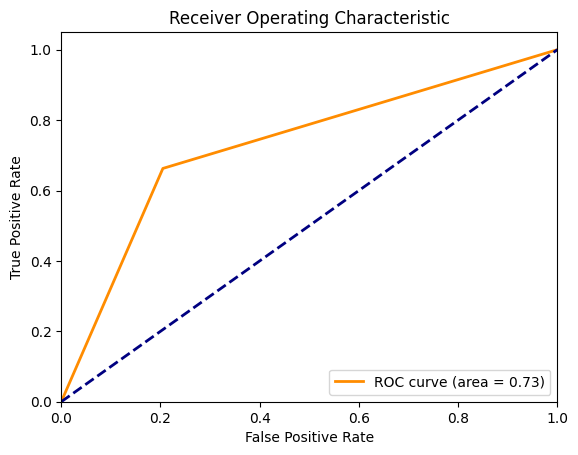

In [ ]:
# Evaluate predictions
evaluate_predictions(predictions, labels_list)

In [6]:
def classify_images_in_directory(image_dir, model, preprocess, tokenized_prompts, classes, device):
    """
    Classify all images in a directory using zero-shot classification.
    
    Args:
        image_dir (str): Path to the directory containing images.
        model (torch.nn.Module): Pretrained model for classification.
        preprocess (callable): Preprocessing function for the images.
        tokenized_prompts (torch.Tensor): Tokenized prompts for the classes.
        classes (list): List of class names.
        device (torch.device): Device to run the model on (CPU or GPU).
    
    Returns:
        dict: A dictionary with image filenames as keys and predicted classes as values.
    """
    predictions = {}
    
    for image_file in tqdm(os.listdir(image_dir)):
        if image_file.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            image_path = os.path.join(image_dir, image_file)
            image = preprocess_image(image_path).to(device)
            
            with torch.inference_mode():
                image_embs = model.encode_image(image)
                text_embs = model.encode_text(tokenized_prompts)
                sim_scores = (image_embs @ text_embs.T * model.logit_scale.exp()).softmax(dim=-1).cpu().numpy()
            
            predicted_class = classes[sim_scores.argmax()]
            predictions[image_file] = predicted_class
    
    return predictions

# Example usage
image_dir = 'path/to/your/image/directory'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
predictions = classify_images_in_directory(image_dir, model, preprocess, tokenized_prompts, classes, device)

# Print predictions
for image_file, predicted_class in predictions.items():
    print(f"{image_file}: {predicted_class}")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'path/to/your/image/directory'

In [14]:
# Extract embeddings from saved tensors
def extract_embeddings(tensor_folder, output_folder, model):
    """
    Extract embeddings from preprocessed tensors and save them.
    Args:
        tensor_folder (str): Path to the folder containing preprocessed tensors.
        output_folder (str): Path to save the extracted embeddings.
        model (torch.nn.Module): Pretrained model for feature extraction.
    """
    os.makedirs(output_folder, exist_ok=True)  # Create output directory if not exist

    for tensor_file in tqdm(os.listdir(tensor_folder)):
        if tensor_file.endswith(".pt"):
            tensor_path = os.path.join(tensor_folder, tensor_file)
            tensor = torch.load(tensor_path).to(device)

            with torch.inference_mode():
                embeddings = model.encode_image(tensor)

            # Save the embeddings with the same name as the tensor file
            embedding_path = os.path.join(output_folder, tensor_file.replace('.pt', '_embeddings.pt'))
            torch.save(embeddings, embedding_path)

# Example usage
tensor_folder = r"C:\Users\Vivian\Documents\CONCH\data_tensors"
embedding_output_folder = r"C:\Users\Vivian\Documents\CONCH\data_embeddings"

extract_embeddings(tensor_folder, embedding_output_folder, model)
print("Embedding Extraction Complete")

  0%|          | 0/7909 [00:00<?, ?it/s]C:\Users\Vivian\AppData\Local\Temp\ipykernel_2752\1785422770.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load

Embedding Extraction Complete


In [17]:
# %pip install scikit-learn

import os
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Define the labels
labels_list = ['B_A', 'B_F', 'B_PT', 'B_TA', 'M_DC', 'M_LC', 'M_MC', 'M_PC']

# Function to extract label from filename
def extract_label_from_filename(filename, labels_list):
    for label in labels_list:
        if label in filename:
            return label
    return None

# Function to load features and labels
def load_features_and_labels(feature_folder, labels_list):
    features = []
    labels = []
    for feature_file in os.listdir(feature_folder):
        if feature_file.endswith("_features.pt"):
            feature_path = os.path.join(feature_folder, feature_file)
            feature = torch.load(feature_path).to('cpu').numpy()
            feature = feature.flatten()
            features.append(feature)
            label = extract_label_from_filename(feature_file, labels_list)
            if label:
                labels.append(label)
    return np.array(features), np.array(labels)

# Load data
feature_folder = r"C:\Users\Vivian\Documents\CONCH\data_embeddings"
X, y = load_features_and_labels(feature_folder, labels_list)

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Binarize the labels for ROC curve plotting
y_train_bin = label_binarize(y_train, classes=labels_list)
y_test_bin = label_binarize(y_test, classes=labels_list)

# Train logistic regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict on test data
y_pred = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.